## 豆瓣250数据分析

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
# import matplotlib
import math
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from PIL import Image

# matplotlib中文显示设置对seaborn无效，采用如下方式可行：
# matplotlib.rcParams['font.family']='SimHei' # 修改了全局变量
# matplotlib.rcParams['font.size']=20
#指定默认字体
mp.rcParams['font.sans-serif'] = ['SimHei']
mp.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
mp.rcParams['axes.unicode_minus'] = False
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

### 目标对爬取的top250的豆瓣数据进行分析

In [43]:
df_data = pd.read_csv('douban250.csv')
df_data.describe()

,movie_num,movie_score
count,250.000000,250.000000
mean,125.500000,8.867200
std,72.312977,0.271623
min,1.000000,8.300000
25%,63.250000,8.700000
50%,125.500000,8.800000
75%,187.750000,9.000000
max,250.000000,9.700000


In [44]:
df_data.describe(include=['O'])

,movie_name,movie_director,movie_star,movie_year,movie_country,movie_type,movie_intro,movie_url
count,250,250,237,250,250,250,245,250
unique,250,186,225,55,65,128,245,250
top,飞越疯人院 /One Flew Over the Cuckoo's Nest /飞越杜鹃窝(...,宫崎骏 Hayao Miyazaki,汤姆·汉克斯 Tom Hanks,2004,美国,剧情,天使暂时离开。,https://movie.douban.com/subject/1296996/
freq,1,7,3,14,80,20,1,1


### 单特性分析

In [45]:
def plot_distribution(dataset, cols=3, width=20, height=15, hspace=0.2, wspace=0.5):
    mp.style.use('seaborn-whitegrid')
    fig = mp.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            mp.xticks(rotation=25)
        else:
            #直方图，频数
            g = sns.distplot(dataset[column])
            mp.xticks(rotation=25)

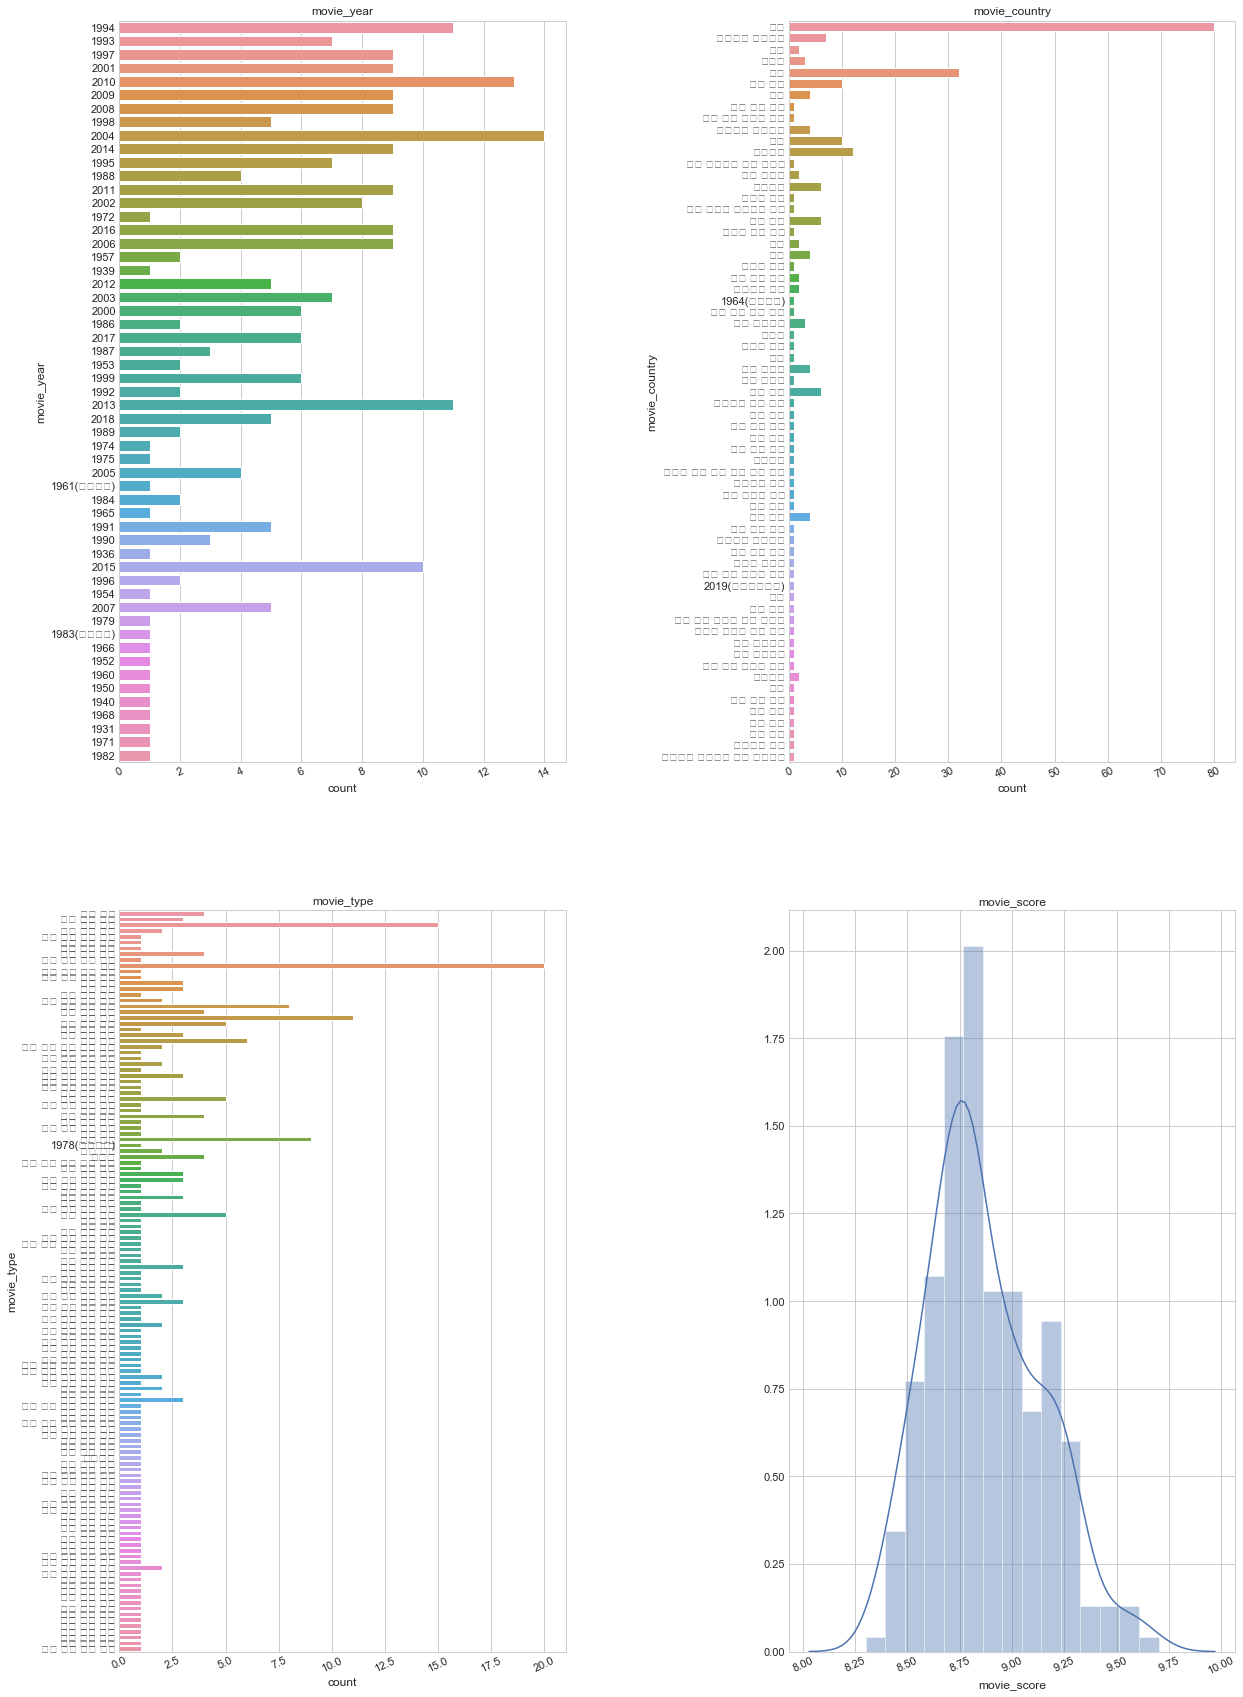

In [47]:
plot_distribution(dataset=df_data.loc[:,['movie_year','movie_country','movie_type','movie_score']],height=30,cols=2)

### 两个变量分析

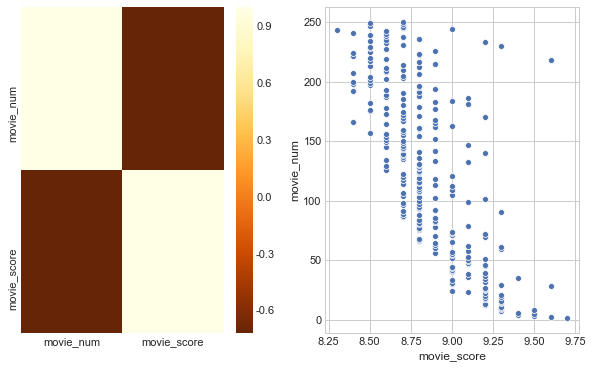

In [51]:
#评分和排名的关系
# 相关系数热力图
fig = mp.figure(figsize=(10,6))
fig.add_subplot(1,2,1)
sns.heatmap(data=df_data.corr(),cmap="YlOrBr_r")
fig.add_subplot(1,2,2)
sns.scatterplot(x='movie_score',y='movie_num',data=df_data)

In [52]:
## 数据清洗
# 处理数据中，错误数据
df_data.loc[(df_data['movie_country'] == '1964(中国大陆)') | (df_data['movie_country'] == '2019(中国大陆重映)'),'movie_country'] = '中国大陆'

df_data.loc[df_data.movie_type == '1978(中国大陆)','movie_type'] = '动画 奇幻'
df_data.loc[df_data.movie_type == '中国大陆','movie_type'] = '动画 奇幻'

In [54]:
#a.	重复值检查（检查是否有重名电影）
movieCount = len(df_data['movie_name'].unique())
print("数据总共有250条，检查重名的数量%s，所以没有重名" % movieCount)

数据总共有250条，检查重名的数量250，所以没有重名


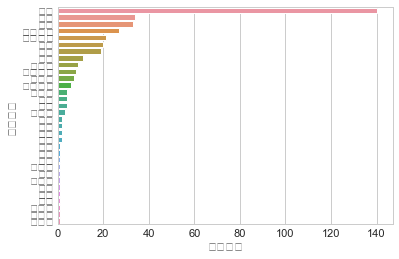

In [55]:
# b.	查看国家或地区与电影制作的排名情况
# c.	统计每个区域里相同国家的总数。
# d.	计算每个国家参与制作的电影总数排名情况
contry = df_data['movie_country'].str.split(' ').apply(pd.Series)
contry = contry.apply(pd.Series.value_counts)
contry.fillna(value=0, inplace=True)
# contry.rename({0: 'a1', 1: 'a2', 2: 'a3', 3: 'a4', 4: 'a5', 5: 'a6'}, inplace=True, axis=1)
contry = contry.sum(axis=1).sort_values(ascending=False)
contry = pd.DataFrame({'国家名称':contry.index,'国家数量':contry.values})
sns.barplot(x='国家数量',y='国家名称',data=contry)

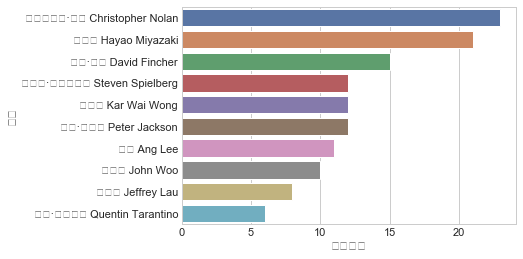

In [61]:
# e.获取电影类型数量前10的类型及上榜次数最多的导演
types = df_data['movie_type'].str.split(' ').apply(pd.Series)
types = types.apply(pd.Series.value_counts)
types.fillna(value=0,inplace=True)
# 获取前10的类型
top10Types = pd.Series(types.sum(axis=1).sort_values(ascending=False),dtype=int).head(10)
top10index = top10Types.index.tolist()
def caculateTypeNum(item):
    list = item['movie_type'].split(' ')
    count = 0
    for i in list:
        if i in top10index:
            count = count+1
    item['actorTop'] = count
    return item

df_data['actorTop'] = 0

result = df_data.apply(caculateTypeNum,axis=1)
resuntgb = result.groupby(by='movie_director')[['actorTop']].sum()

resuntgb = resuntgb.sort_values(by=['actorTop'], ascending=False).head(10)
resuntgb = pd.DataFrame({"导演":resuntgb.index,"类型数量":resuntgb.actorTop.values})
sns.barplot(x='类型数量',y='导演',data=resuntgb)

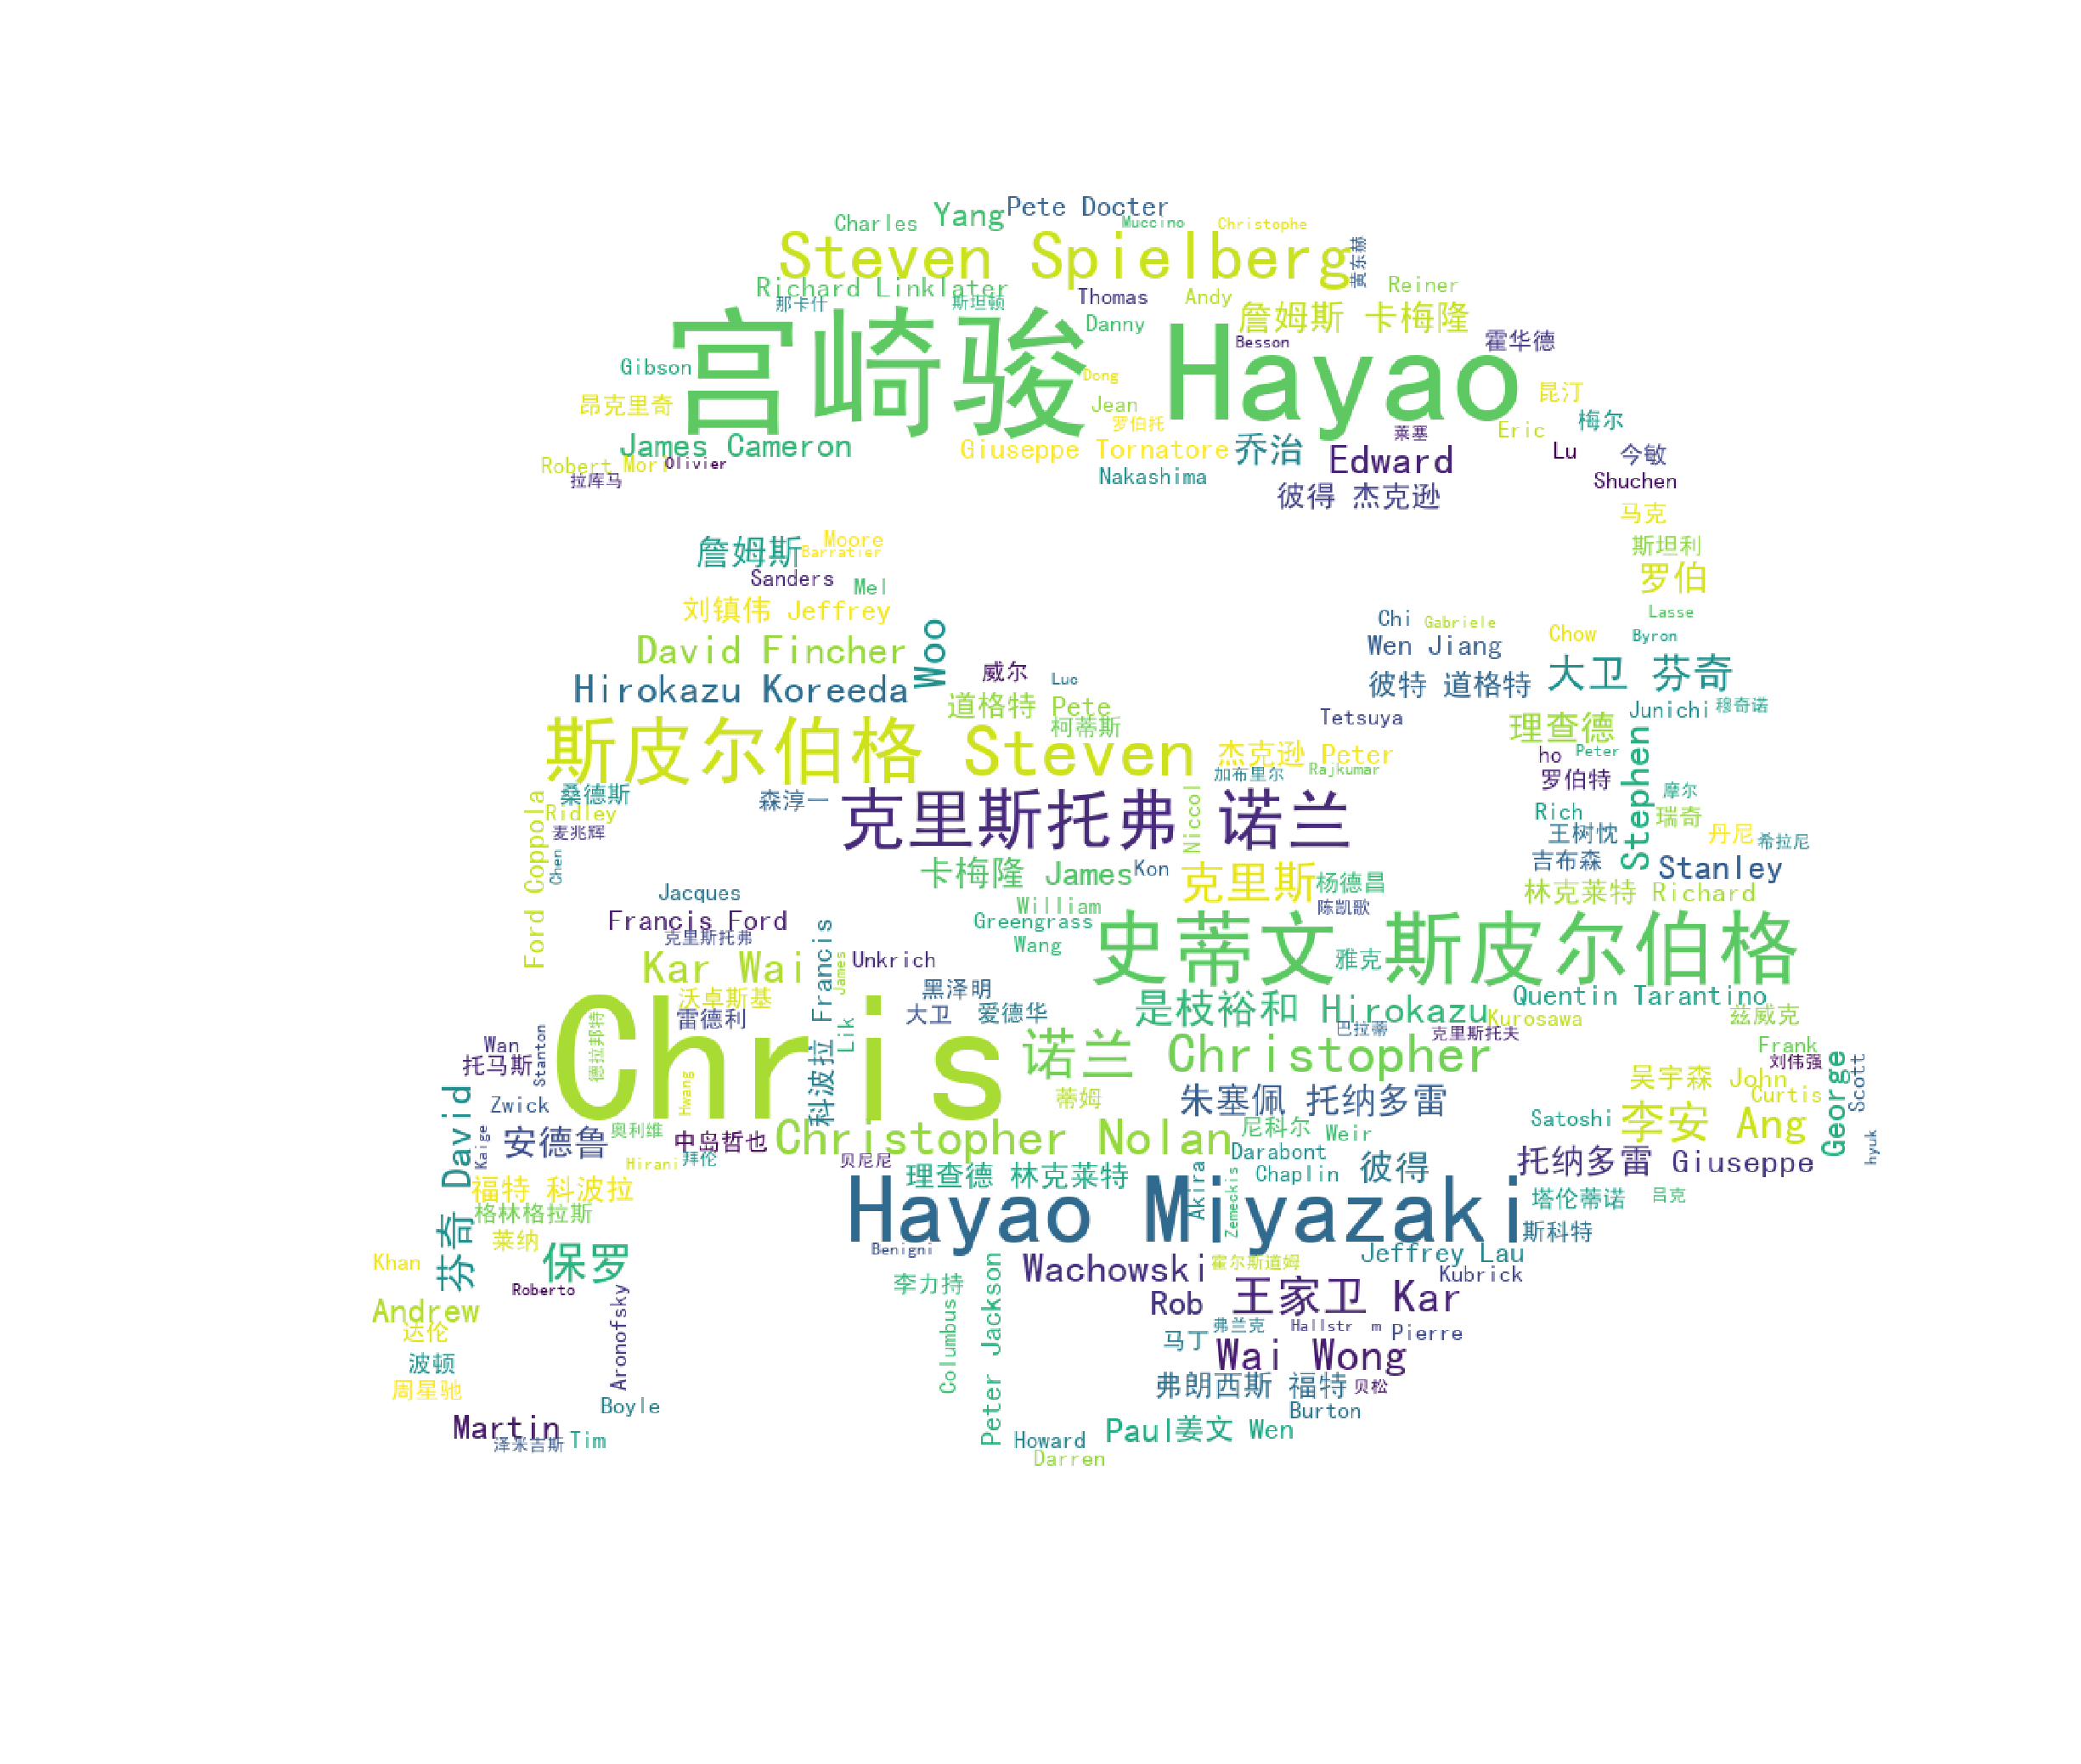

In [66]:
# 导演名称词云

s_mask = np.array(Image.open("stormtrooper_mask.png"))
stopwords = set(STOPWORDS)
stopwords.add("lee")

mytext = ' '.join(df_data['movie_director'].tolist())
wc1 = WordCloud(
    background_color='white',  # 背景色
    width=2000,  # 宽度
    height=1000,  # 高度
    font_path='simhei.TTF',  # 字体文件，此处与py文件放在同一目录
mask=s_mask, stopwords=stopwords,
    margin=1  # 词语边缘距离
)
wc2 = wc1.generate(mytext)  # 绘制词云
mp.rcParams['figure.dpi'] = 600  # 修改dpi
mp.rcParams['savefig.dpi']=600   # 修改dpi
mp.axis('off')
mp.imshow(wc2)

# plt.savefig('{}.jpg'.format(filename))
mp.show()